In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import os
import torch
from pathlib import Path
import numpy as np
from jarvis.utils import tqdm

FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)
rng = np.random.default_rng()

# Gather precomputed beliefs and monkey actions

In [2]:
from hexarena.scripts.common import get_block_ids, create_env_and_model
from hexarena.scripts.compute_beliefs import fetch_beliefs

subject, kappa, num_samples = 'marco', 0.1, 1000
env, model = create_env_and_model(subject, kappa)

block_ids = get_block_ids(subject, kappa)
pi_inputs, actions = [], []
for session_id, block_idx in tqdm(block_ids, unit='block'):
    _, _actions, _knowns, _beliefs = fetch_beliefs(subject, kappa, num_samples, session_id, block_idx)
    _pi_inputs = torch.cat([model.ebd_k.embed(torch.tensor(_knowns)), _beliefs], dim=1)[:-1]
    
    # T = len(_actions)
    # _pi_inputs = _pi_inputs[T//2:]
    # _actions = _actions[T//2:]
    pi_inputs.append(_pi_inputs)
    actions.append(torch.tensor(_actions, dtype=torch.long))
pi_inputs = torch.cat(pi_inputs) # inputs for policies
actions = torch.cat(actions) # monkey actions

  0%|                                                                                                         …

# Gather agents trained with different subjective parameters

In [3]:
from hexarena.scripts.train_agents import create_manager

manager = create_manager(subject, kappa, num_samples)
keys = []
for key, _ in manager.completed(min_epoch=10, cond={'model': {'kappa': kappa, 'num_samples': num_samples}}):
    ckpt = manager.ckpts[key]
    if ckpt['optimality']>=0.99:
        keys.append(key)
print('{} agents found'.format(len(keys)))

1167 agents found


## Compute data likelihood for each agent

In [4]:
names = [
    'push_cost', 'reward', 'turn_price', 'move_price', 'center_cost', 'gamma', 'ent_coef',
]

# log_lls = {}
params, log_lls = [], []
for key in tqdm(keys, unit='Agent'):
    config = manager.configs[key]
    param = tuple(config[k] for k in names)    
    manager.setup(config)
    manager.load_ckpt(manager.ckpts[key])
    with torch.no_grad():
        dists = manager.algo.policy.get_distribution(pi_inputs).distribution
    log_ll = dists.log_prob(actions).mean().item()

    # if param not in log_lls or log_lls[param]<log_ll:
    #     log_lls[param] = log_ll
    params.append(param)
    log_lls.append(log_ll)
# params = np.stack(list(log_lls.keys()))
# log_lls = np.array([log_lls[tuple(param)] for param in params])
params = np.array(params)
log_lls = np.array(log_lls)

  0%|                                                                                                         …

## Convert parameters to unbounded values

In [5]:
params_lb = params.min(axis=0)
params_ub = params.max(axis=0)
margin = (params_ub-params_lb)/20
params_lb -= margin
params_ub += margin
params_lb[5] = max(params_lb[5], 0)
params_ub[5] = min(params_ub[5], 1)
params_lb[6] = max(params_lb[6], 0)

In [6]:
thetas = np.log(params-params_lb)-np.log(params_ub-params)

## Create a multilayer perceptron to fit log likelihoods

In [11]:
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim import SGD

def train_net(net, thetas, log_lls, num_epochs=400, seed=0):
    dset = TensorDataset(torch.tensor(thetas, dtype=torch.float), torch.tensor(log_lls, dtype=torch.float)[:, None])
    dset_train, dset_test = random_split(dset, [0.8, 0.2], generator=torch.Generator().manual_seed(seed))
    loader = DataLoader(dset_train, batch_size=16, shuffle=True, drop_last=True)
    optimizer = SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.001)
    
    losses = []
    min_loss, best_state = float('inf'), None
    for _ in tqdm(range(num_epochs), unit='epoch', leave=False):
        for inputs, targets in loader:
            preds = net(inputs)
            loss = (preds-targets).pow(2).mean()
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        inputs, targets = dset_test[:]
        with torch.no_grad():
            preds = net(inputs)
        loss = (preds-targets).pow(2).mean().item()
        losses.append(loss)
        if loss<min_loss:
            min_loss = loss
            best_state = {k: v.clone() for k, v in net.state_dict().items()}
    losses = np.array(losses)
    net.load_state_dict(best_state)
    return losses

In [12]:
from jarvis.utils import create_mlp_layers
from torch.nn import Sequential

num_nets = 10
nets = [
    Sequential(*create_mlp_layers(
        len(names), 1, num_features=[128, 32], nonlinearity='Softplus',
    )) for _ in range(num_nets)
]
num_epochs = 400
losses_test = []
for i in tqdm(range(num_nets), unit='net'):
    losses_test.append(train_net(nets[i], thetas, log_lls, num_epochs, seed=i))
losses_test = np.stack(losses_test)

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

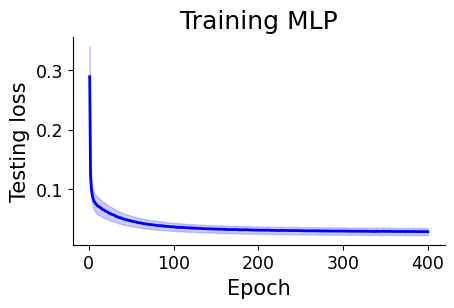

In [9]:
losses_mean = losses_test.mean(axis=0)
losses_std = losses_test.std(axis=0)

_, ax = plt.subplots()
ax.plot(np.arange(num_epochs)+1, losses_mean, color='blue')
ax.fill_between(np.arange(num_epochs)+1, losses_mean-losses_std, losses_mean+losses_std, color='blue', alpha=0.2)
ax.set_title('Training MLP')
ax.set_ylabel('Testing loss')
ax.set_xlabel('Epoch')
plt.show()

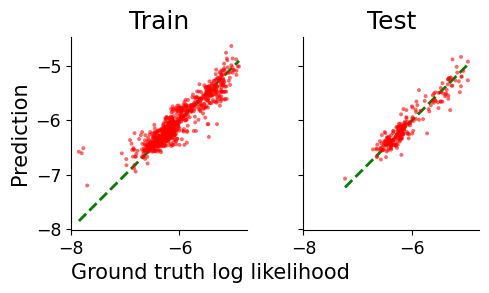

In [13]:
seed = rng.choice(num_nets)
net = nets[seed]
dset = TensorDataset(torch.tensor(thetas, dtype=torch.float), torch.tensor(log_lls, dtype=torch.float)[:, None])
dset_train, dset_test = random_split(dset, [0.8, 0.2], generator=torch.Generator().manual_seed(seed))

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5.5, 2.5))
for i, ax in enumerate(axes):
    if i==0:
        inputs, targets = dset_train[:]
        title = 'Train'
    if i==1:
        inputs, targets = dset_test[:]
        title = 'Test'
    with torch.no_grad():
        preds = net(inputs)
    ax.scatter(targets, preds, s=8, c='red', alpha=0.6, edgecolor='none')
    vmin, vmax = targets.min(), targets.max()
    ax.plot([vmin, vmax], [vmin, vmax], color='green', linestyle='--', zorder=0)
    ax.set_title(title)
    ax.set_aspect('equal')
ax = axes[0]
ax.set_xlabel('Ground truth log likelihood', loc='left')
ax.set_ylabel('Prediction')
fig.savefig(FIG_DIR/'likelihood.fit.from.params.svg')
# plt.show()

# Find best parameter via stochastic gradient ascent

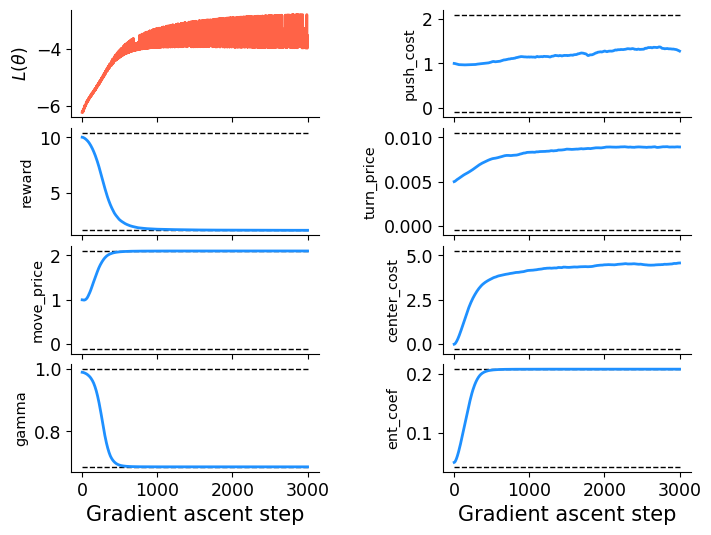

In [14]:
theta = torch.tensor(rng.choice(thetas), dtype=torch.float, requires_grad=True)

optimizer = SGD([theta], lr=0.02, momentum=0.9)
lls_guess, thetas_guess = [], []
num_steps = 3000
for _ in range(num_steps):
    net = nets[rng.choice(num_nets)]
    ll = net(theta)
    lls_guess.append(ll.item())
    thetas_guess.append(theta.data.clone())

    loss = -ll[0]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
lls_guess = np.array(lls_guess)
thetas_guess = torch.stack(thetas_guess)
params_guess = params_lb/(1+np.exp(thetas_guess))+params_ub/(1+np.exp(-thetas_guess))

fig, axes = plt.subplots(4, 2, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.5})
for i, ax in enumerate(axes.ravel(), -1):
    if i==-1:
        ax.plot(lls_guess, color='tomato')
        ax.set_ylabel(r'$L(\theta)$', fontsize='small')
    else:
        ax.plot(params_guess[:, i], color='dodgerblue')
        ax.hlines([params_lb[i], params_ub[i]], 0, num_steps, color='black', linewidth=1, linestyle='--', zorder=0)
        ax.set_ylabel(names[i], fontsize='x-small')
    if ax in axes[-1]:
        ax.set_xlabel('Gradient ascent step')
fig.savefig(FIG_DIR/'irc.subjective.params.svg')

# Distribution of trained agents parameters

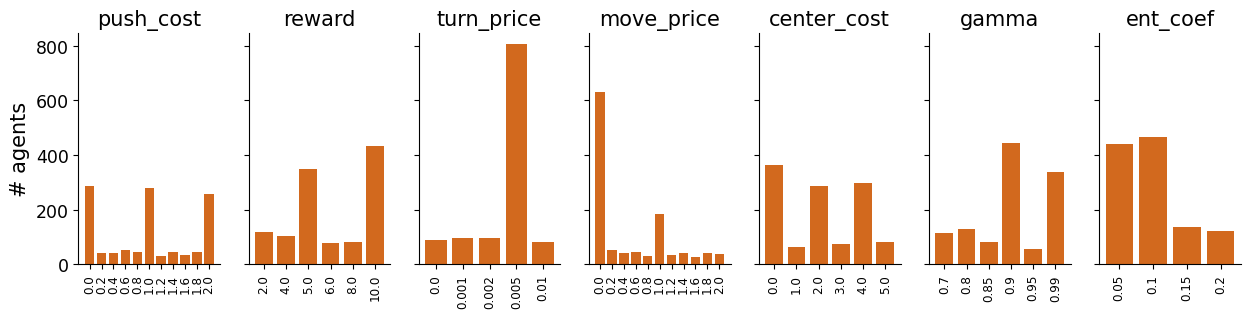

In [15]:
from collections import Counter

Counter(params[:, 0])

fig, axes = plt.subplots(1, 7, sharey=True, figsize=(15, 3))
for i, ax in enumerate(axes):
    counter = Counter(params[:, i])
    vals = sorted(counter.keys())
    ax.bar(np.arange(len(vals)), [counter[v] for v in vals], color='chocolate')
    ax.set_xticks(np.arange(len(vals)))
    ax.set_xticklabels([str(v) for v in vals], rotation=90, fontsize='xx-small')
    ax.set_title(names[i], fontsize='medium')
axes[0].set_ylabel('# agents')
fig.savefig(FIG_DIR/'agent.param.distribution.svg')